# Importing Libraries

In [34]:
import numpy as np
import pandas as pd
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score

from imblearn.over_sampling import RandomOverSampler
import accelerate
import evaluate
from datasets import Dataset, Image, ClassLabel
import transformers

import torch
from torch.utils.data import DataLoader
import torchvision.transforms

from PIL import ImageFile
from pathlib import Path
from tqdm import tqdm
import os


# Importing our data

In [35]:
image_dict = {}

# Use glob to find all files with any extension in the target directory
file_paths = sorted(glob('data/*.*'))

file_names = []
labels = []

for file in tqdm(file_paths):
    file_names.append(file)  # Add the file path to the list
    # Extract labels from filename (last part after splitting by os.sep), splitting by '_' and joining first two parts
    labelss = ' '.join(os.path.basename(file).split('_')[:2])
    labels.append(labelss)

print(len(file_names), len(labels), len(set(labels)))

df = pd.DataFrame.from_dict({"image": file_names, "labels": labels})


100%|██████████| 64467/64467 [00:00<00:00, 185533.43it/s]

64467 64467 323


In [36]:
df.head()

,image,labels
0,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...,Acura ILX
1,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...,Acura ILX
2,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...,Acura ILX
3,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...,Acura ILX
4,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...,Acura ILX


In [37]:
df.info()       # We don't have any null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64467 entries, 0 to 64466
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   64467 non-null  object
 1   labels  64467 non-null  object
dtypes: object(2)
memory usage: 1007.4+ KB


In [38]:
df.shape

(64467, 2)

## viewing our labels

In [39]:

print(f"The number of car models in the dataset is ({df['labels'].nunique()})")
print(f"""\n============================================
      The models we have in our dataset
      \n{df['labels'].unique()}  """)

The number of car models in the dataset is (323)

      The models we have in our dataset
      
['Acura ILX' 'Acura MDX' 'Acura NSX' 'Acura RDX' 'Acura RLX' 'Acura TLX'
 'Alfa Romeo 4C Spider' 'Alfa Romeo 4C' 'Alfa Romeo Giulia'
 'Alfa Romeo Stelvio' 'Aston Martin DB11' 'Aston Martin DBS'
 'Aston Martin Vanquish' 'Aston Martin Vantage' 'Audi A3' 'Audi A4'
 'Audi A5' 'Audi A6' 'Audi A7' 'Audi A8' 'Audi Q3' 'Audi Q5' 'Audi Q7'
 'Audi Q8' 'Audi R8' 'Audi TT' 'Audi e-tron' 'BMW 2-Series' 'BMW 3-Series'
 'BMW 4-Series' 'BMW 5-Series' 'BMW 6-Series' 'BMW 7-Series'
 'BMW 8-Series' 'BMW X1' 'BMW X2' 'BMW X3' 'BMW X4' 'BMW X5' 'BMW X6'
 'BMW X7' 'BMW Z4' 'BMW i3' 'BMW i8' 'Bentley Bentayga'
 'Bentley Continental GT' 'Bentley Flying Spur' 'Bentley Mulsanne'
 'Buick Cascada' 'Buick Enclave' 'Buick Encore' 'Buick Envision'
 'Buick Lacrosse' 'Buick Regal' 'Cadillac ATS' 'Cadillac CT4'
 'Cadillac CT5' 'Cadillac CT6' 'Cadillac CTS' 'Cadillac Escalade'
 'Cadillac XT4' 'Cadillac XT5' 'Cadillac XT6' 'C

# Checking for data imbalance

In [40]:
print(df['labels'].value_counts())

labels
MINI Cooper               539
Ford Ranger               504
Ford F-150                485
Honda Civic               480
Chevrolet Colorado        479
                         ... 
Toyota Yaris Hatchback      1
Mazda Mazda3 Hatchback      1
Ferrari Portofino           1
Porsche 718 Spyder          1
Subaru STI S209             1
Name: count, Length: 323, dtype: int64


## Since data imbalance was found to be present. We need to try to oversample the minorities class
> **Note:** Since this isn't a tabular data I would prefer to use `Random Oversampler` as it duplicates already existing rows

### Splitting the data

In [41]:
y = df['labels']
df = df.drop('labels',axis=1)
df.head()

,image
0,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...
1,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...
2,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...
3,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...
4,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...


In [42]:
# Intiating our sampler
ros = RandomOverSampler(random_state=42)

df, y_resampled = ros.fit_resample(df,y)

# Deleting the Original y variable data to save memory and prevent any intercept
del y 

df['labels'] = y_resampled

# Deleteing the temporary resampled variable
del y_resampled

### Viewing the new data head, shape and checking for the data imbalance once again

In [43]:
df.head()

,image,labels
0,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...,Acura ILX
1,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...,Acura ILX
2,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...,Acura ILX
3,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...,Acura ILX
4,data\Acura_ILX_2013_28_16_110_15_4_70_55_179_3...,Acura ILX


In [44]:
df.shape

(174097, 2)

In [45]:
print(df['labels'].value_counts())

labels
smart fortwo            539
Acura ILX               539
Acura MDX               539
Subaru WRX              539
Tesla Model 3           539
                       ... 
Alfa Romeo 4C Spider    539
Alfa Romeo 4C           539
Alfa Romeo Giulia       539
Alfa Romeo Stelvio      539
Aston Martin DB11       539
Name: count, Length: 323, dtype: int64


# Segmenting a smaller part from our dataset so the training is faster

In [46]:
df = df.sample(int(10e4))

# Creating a dataset from our pandas data frame so we can feed it using the data loader

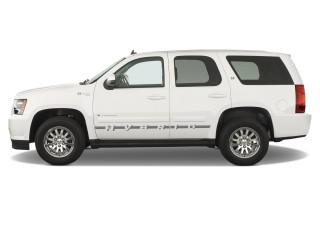

In [47]:
ds = Dataset.from_pandas(df).cast_column('image', Image())
"""
Converts a Pandas DataFrame (df) into a Hugging Face Dataset object.
The cast_column method changes the type of a specific column in the dataset.
Image() is a special Hugging Face datasets feature type that represents image files.
"""

# Example from our dataset
ds[21]['image']

# Creating the labels2id and id2labels dictionaries which are necessary for our transformer training

In [48]:
labels_list = sorted(list(set(labels)))
"""
This Creates a set from our labels which prevent the presence of any duplicates
then append it to a list that finally gets sorted
"""

# Intializing the labels2id and id2labels dictionaries
label2id, id2label = dict(), dict()

for i, labels in enumerate(labels_list):
    label2id[labels] = i         # Links the labels itself to the index aka id
    id2label[i] = labels         # Links the index (ID) to the labels name

print(label2id)
print("====================================")
print(id2label)

{'Acura ILX': 0, 'Acura MDX': 1, 'Acura NSX': 2, 'Acura RDX': 3, 'Acura RLX': 4, 'Acura TLX': 5, 'Alfa Romeo 4C': 6, 'Alfa Romeo 4C Spider': 7, 'Alfa Romeo Giulia': 8, 'Alfa Romeo Stelvio': 9, 'Aston Martin DB11': 10, 'Aston Martin DBS': 11, 'Aston Martin Vanquish': 12, 'Aston Martin Vantage': 13, 'Audi A3': 14, 'Audi A4': 15, 'Audi A5': 16, 'Audi A6': 17, 'Audi A7': 18, 'Audi A8': 19, 'Audi Q3': 20, 'Audi Q5': 21, 'Audi Q7': 22, 'Audi Q8': 23, 'Audi R8': 24, 'Audi TT': 25, 'Audi e-tron': 26, 'BMW 2-Series': 27, 'BMW 3-Series': 28, 'BMW 4-Series': 29, 'BMW 5-Series': 30, 'BMW 6-Series': 31, 'BMW 7-Series': 32, 'BMW 8-Series': 33, 'BMW X1': 34, 'BMW X2': 35, 'BMW X3': 36, 'BMW X4': 37, 'BMW X5': 38, 'BMW X6': 39, 'BMW X7': 40, 'BMW Z4': 41, 'BMW i3': 42, 'BMW i8': 43, 'Bentley Bentayga': 44, 'Bentley Continental GT': 45, 'Bentley Flying Spur': 46, 'Bentley Mulsanne': 47, 'Buick Cascada': 48, 'Buick Enclave': 49, 'Buick Encore': 50, 'Buick Envision': 51, 'Buick Lacrosse': 52, 'Buick Rega

# Creating classlabels to encode our data in the dataset

In [49]:
from datasets import ClassLabel

class_labels = ClassLabel(names=labels_list)

# Map string labels to IDs
def map_labels2id(example):
    example['labels'] = class_labels.str2int(example['labels'])
    return example

# Map function to dataset
ds = ds.map(map_labels2id, batched=True)

# Cast 'labels' column to Classlabels type
ds = ds.cast_column('labels', class_labels)


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/100000 [00:00<?, ? examples/s]

# Splitting the data after the preprocessing to train and test sets

In [50]:
ds = ds.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="labels")
# `stratify_by_column` It ensures the train and test splits preserve the same class distribution as the original dataset based on the "labels" column.

print(ds)

# Extracting the training data from the split dataset.
train_data = ds['train']

# Extracting the testing data from the split dataset.
test_data = ds['test']

DatasetDict({
    train: Dataset({
        features: ['image', 'labels', '__index_level_0__'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'labels', '__index_level_0__'],
        num_rows: 40000
    })
})


# Setting up our images for model training

In [51]:
from transformers import ViTImageProcessor

# Intiating the image processor for that model
processor = ViTImageProcessor('google/vit-base-patch16-224-in21k')


## Pre-processing our images before feeding it into our mode

In [52]:
# Getting the variables needed for image normalization
img_mean, img_std = processor.image_mean, processor.image_std

In [53]:
# getting the image size to resize our images

img_size = processor.size['height']     # Can use either width or height as both are (224)

img_size

224

In [54]:
from torchvision.transforms import Normalize
# Identifying our normalization parameters
normalizer = Normalize(img_mean, img_std)

In [55]:
from torchvision.transforms import Compose, Resize, RandomRotation, RandomAdjustSharpness, RandomHorizontalFlip, ToTensor

# Identifying the transformations for our train dataset
train_transformation = Compose(
    [
        Resize((img_size, img_size)),       # Resizes the image
        RandomRotation(10),                 # Adds random rotations to the images
        RandomAdjustSharpness(2),           # Adjusts the sharpness of the images randomly
        RandomHorizontalFlip(0.5),          # Apply random horizontal flips to the images
        ToTensor(),                         # Converts the image to tensors for the machine learning process
        normalizer                          # Normalize the tensors using the normalizer parameters we have defined
    ]
)

# Identify the transfomations for our test dataset
test_transformation = Compose(
    [
        Resize((img_size, img_size)),
        ToTensor(),
        normalizer
    ]
)


In [56]:
# Creating function to map transformations to the train dataset

def train_transform(examples):
    examples['pixel_values'] = [train_transformation(img.convert("RGB")) for img in examples['image']]
    return examples

def test_transform(examples):
    examples['pixel_values'] = [test_transformation(img.convert("RGB")) for img in examples['image']]
    return examples



## Applying the transformation functions to our data using lazy loading

In [57]:
# Applying for our training dataset
train_data.set_transform(train_transform)

# Applying for our test dataset
test_data.set_transform(test_transform)

# Identifying the dataloader, evaluation metrics, training arguments and trainer parameters

## DataLoader

In [58]:
def collate_fn(examples):
    # Ensure all pixel_values are stacked into a 4D tensor: [batch_size, 3, H, W]
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    
    # Ensure labels are collected as a 1D tensor of integers
    labels = torch.tensor([int(example['labels']) for example in examples], dtype=torch.long)
    
    return {"pixel_values": pixel_values, "labels": labels}


## Model Intialization

In [59]:
from transformers import ViTForImageClassification
# Intiating our pretrained model
model_name = 'google/vit-base-patch16-224-in21k'

model = ViTForImageClassification.from_pretrained(model_name, num_labels = len(labels_list))

# Configure the mapping of class labels to their corresponding indices.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and display the number of trainable parameters (in millions) in the model
print(f"Number of trainable parameters: {model.num_parameters(only_trainable=True) / 1e6:.2f} million")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of trainable parameters: 86.05 million


## Evaluation metrics

In [60]:
# Load accuracy metric (already imported via evaluate)
accuracy = evaluate.load("accuracy")

# Define metric computation function for evaluation
def compute_metrics(eval_pred):
    preds = eval_pred.predictions.argmax(axis=1)  # Get predicted class labels
    labels = eval_pred.label_ids                 # Get true labels
    return accuracy.compute(predictions=preds, references=labels)

## Training Arguments

In [61]:
from transformers import TrainingArguments

# Define model name and number of training epochs
model_name = "./car_models_image_classifier"
num_train_epochs = 10

# Configure training settings
args = TrainingArguments(
    output_dir=model_name,                 # Where to save model checkpoints
    logging_dir="./logs",                  # Where to save training logs
    logging_strategy="epoch",              # Log training loss
    eval_strategy="epoch",          # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoints per epoch
    learning_rate=1.5e-5,                 # Initial learning rate
    per_device_train_batch_size=16,       # Training batch size per device
    per_device_eval_batch_size=16,         # Evaluation batch size per device
    num_train_epochs=num_train_epochs,    # Total training epochs
    weight_decay=0.01,                    # Apply weight decay for regularization
    warmup_steps=50,                      # Learning rate warm-up steps
    remove_unused_columns=False,          # Keep all dataset columns
    load_best_model_at_end=True,          # Reload best checkpoint at the end
    save_total_limit=1,                   # Keep only the best checkpoint
    report_to="none"                      # Disable reporting (e.g., WandB, TensorBoard)
)


## Trainer Parameters

In [62]:
from transformers import Trainer
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

C:\Users\maraw\AppData\Local\Temp\ipykernel_9772\3566567214.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [63]:
print(test_data.column_names)


['image', 'labels', '__index_level_0__']


In [64]:
# Evaluate the model before training on the test dataset.
# This provides a baseline by computing metrics like accuracy and loss
# to understand how the untrained or pretrained model performs on unseen data.

trainer.evaluate()


{'eval_loss': 5.779440879821777,
 'eval_model_preparation_time': 0.004,
 'eval_accuracy': 0.0032,
 'eval_runtime': 308.3904,
 'eval_samples_per_second': 129.706,
 'eval_steps_per_second': 8.107}

# Model Training

In [65]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,5.390000,4.980709,0.004000,0.254075
2,4.551000,4.207791,0.004000,0.389200
3,3.734800,3.455834,0.004000,0.509750
4,2.977200,2.797439,0.004000,0.604825
5,2.330800,2.276062,0.004000,0.678075
6,1.822000,1.883612,0.004000,0.727350
7,1.444000,1.611190,0.004000,0.765175
8,1.181200,1.428384,0.004000,0.789800
9,1.012600,1.325848,0.004000,0.801750
10,0.924000,1.288467,0.004000,0.807250


TrainOutput(global_step=37500, training_loss=2.53675953125, metrics={'train_runtime': 17731.5788, 'train_samples_per_second': 33.838, 'train_steps_per_second': 2.115, 'total_flos': 4.66289614393344e+19, 'train_loss': 2.53675953125, 'epoch': 10.0})

In [67]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Run prediction
outputs = trainer.predict(test_data)

# Extract predictions and true labels
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(axis=1)

# Compute accuracy and macro F1 score
acc_score = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"✅ Accuracy:     {acc_score:.4f}")
print(f"✅ Macro F1 Score: {f1:.4f}\n")

# Print detailed classification report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

✅ Accuracy:     0.8073
✅ Macro F1 Score: 0.7999

📋 Classification Report:

                               precision    recall  f1-score   support

                    Acura ILX     0.6343    0.8952    0.7425       124
                    Acura MDX     0.7132    0.7293    0.7212       133
                    Acura NSX     0.8889    0.7879    0.8353       132
                    Acura RDX     0.9195    0.6612    0.7692       121
                    Acura RLX     0.6687    0.8560    0.7509       125
                    Acura TLX     0.7422    0.8190    0.7787       116
                Alfa Romeo 4C     0.9194    0.9194    0.9194       124
         Alfa Romeo 4C Spider     0.9837    1.0000    0.9918       121
            Alfa Romeo Giulia     0.9275    1.0000    0.9624       128
           Alfa Romeo Stelvio     0.9000    1.0000    0.9474       126
            Aston Martin DB11     0.8582    1.0000    0.9237       121
             Aston Martin DBS     0.9727    0.8917    0.9304       120
 